In [1]:
import tensorflow as tf
from tensorflow.keras import Input
test_dir = "./Human_Emotion_Dataset/EmotionsDataset_Splitted/data/test"
train_dir = "./Human_Emotion_Dataset/EmotionsDataset_Splitted/data/train"
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import GlobalAveragePooling2D , Layer , Add , Embedding , LayerNormalization , MultiHeadAttention , Resizing ,  Rescaling , Permute
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dropout,
    InputLayer,
    BatchNormalization,
    MaxPooling2D,
    MaxPool2D,
)

import numpy as np
from tensorflow.keras.losses import (
    SparseCategoricalCrossentropy,
    categorical_crossentropy,
    CategoricalCrossentropy,
)

from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import L2, l1
from sklearn.metrics import confusion_matrix
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from tensorflow.keras import   Model
# Import the necessary module
from tensorflow.keras.layers import Layer
# Activation import
from tensorflow.keras.activations import relu, sigmoid, softmax 

from tensorflow.keras.layers import Activation
# Define the CustomConv2D class
class CustomConv2D(Layer):
    def __init__(self, n_filters, kernel_size, n_strides, padding='valid'):
        super(CustomConv2D, self).__init__(name='custom_conv2d')
        # Rest of your code for the custom convolution layer implementation

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 4,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "nothing", "sad"],
}

CLASSES = ["angry", "happy", "nothing", "sad"]

In [2]:
train_dataset = image_dataset_from_directory(
    train_dir,
    labels="inferred",  # Means that the labels are inferred from the directory structure automatically
    label_mode="categorical",  # We have to write categorical because we have more than 3 classes.
    # This categorical means that the labels are returned as a one-hot encoded vector
    # This categorical decide we have number of units in dense layer
    # In case of int we have only 1 unit in dense layer
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    class_names=CLASSES,
    seed=99,
    validation_split=0.2,
    subset="training",
)
validation_dataset = image_dataset_from_directory(                                                                              
    train_dir,
    labels="inferred",  # Means that the labels are inferred from the directory structure automatically
    label_mode="categorical",
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    class_names=CLASSES,
    seed=99,
    validation_split=0.2,
    subset="validation",
)
test_dataset = image_dataset_from_directory(
    test_dir,
    labels="inferred",  # Means that the labels are inferred from the directory structure automatically
    label_mode="categorical",
    class_names=CLASSES,
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)


train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)
# .unbatch()    This is used to unbatch the dataset

Found 3152 files belonging to 4 classes.
Using 2522 files for training.
Found 3152 files belonging to 4 classes.
Using 630 files for validation.
Found 788 files belonging to 4 classes.


In [3]:
def single_batch_data_visualization(dataset):
    plt.figure(figsize=(10, 10))
    for batch_images, batch_labels in dataset:
        num_images = len(batch_images)
        print(num_images)
        ro = col = int(num_images**0.5) + 1
        for i, (image, label) in enumerate(zip(batch_images, batch_labels)):
            plt.subplot(ro, col, i + 1)
            ax = plt.subplot(ro, col, i + 1)
            plt.imshow(image.numpy().astype("uint32"))
            plt.title(CLASSES[tf.argmax(label)])
            # print(CLASSES[label])
            plt.axis("off")
            plt.grid(True)

        break

### Sigmoid Works for Binary Classification

### Softmax Works for Multiclass Classification

- Sigmoid gives value from -1 to 1 it best for binary as we calculate between two and output the maximum
- Softmax is best for categorial data as we have to output the probabilities with respect to each other


In [4]:
loss_function = CategoricalCrossentropy(
    from_logits=False
)  # When from_logits is False you are telling the model that you use the softmax probability at the end of the model and sum of all values in the output array is 1

## CategoricalCrossentropy Example


In [ ]:
y_true = [[0, 1, 0], [1, 0, 0]]
y_pred = [[0.9, 0.1, 0.1], [0.6, 0.2, 0.2]]
ans = CategoricalCrossentropy()
loss = ans(y_true, y_pred)
print(loss.numpy())

## SparseCategoricalCrossentropy Example

- When we have
- ----------`y_true in the form of labels`,
- ----------`pred in the form of probability array`
- ---------- then we use the `SparseCategorical`


In [ ]:
y_true = [2, 1]
y_pred = [[0.9, 0.1, 0.1], [0.6, 0.2, 0.2]]
ans = SparseCategoricalCrossentropy()
loss = ans(y_true, y_pred)
print(loss.numpy())

In [ ]:
resize_rescale_layers = tf.keras.Sequential(
    [
        tf.keras.layers.Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
        tf.keras.layers.Rescaling(1.0 / 255),
    ]
)

In [ ]:
import numpy as np
import cv2

ima = cv2.imread(
    "D:/Tensorflow Basics/Human_Emotion_Dataset/Emotions Dataset/Emotions Dataset/test/happy/1705.jpg_brightness_2.jpg"
)
image_shape = ima.shape
print(image_shape)
ima = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
ima = tf.constant(ima, dtype=tf.float32)

In [ ]:
lenet_model = Sequential(
    [
        InputLayer(input_shape=(None, None, 3)),
        resize_rescale_layers,
        Conv2D(
            filters=CONFIGURATION["N_FILTERS"],
            kernel_size=CONFIGURATION["KERNEL_SIZE"],
            strides=CONFIGURATION["N_STRIDES"],
            padding="valid",
            activation="relu",
            kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"]),
        ),
        BatchNormalization(),
        MaxPool2D(
            pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"] * 2
        ),
        Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),
        Conv2D(
            filters=CONFIGURATION["N_FILTERS"] * 2 + 4,
            kernel_size=CONFIGURATION["KERNEL_SIZE"],
            strides=CONFIGURATION["N_STRIDES"],
            padding="valid",
            activation="relu",
            kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"]),
        ),
        BatchNormalization(),
        MaxPool2D(
            pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"] * 2
        ),
        Flatten(),
        Dense(
            CONFIGURATION["N_DENSE_1"],
            activation="relu",
            kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"]),
        ),
        BatchNormalization(),
        Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),
        Dense(
            CONFIGURATION["N_DENSE_2"],
            activation="relu",
            kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"]),
        ),
        BatchNormalization(),
        Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax"),
    ]
)

lenet_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
    run_eagerly=True,
)
lenet_model.summary()

In [ ]:
print(tf.config.list_physical_devices("GPU"))

In [ ]:
lenet_model.fit(train_dataset, validation_data=validation_dataset, epochs=10, verbose=1)

In [ ]:
lenet_model.save_weights("lenet_weights_human_emotions.h5")

In [ ]:
lenet_model.load_weights("lenet_weights_human_emotions.h5")

In [ ]:
lenet_model.evaluate(test_dataset, verbose=1)

In [ ]:
def predicted_single_batch_data_visualization(dataset , model):
    plt.figure(figsize=(15, 15))
    for batch_images, batch_labels in dataset:
        num_images = len(batch_images)
        print(num_images)
        ro = col = int(num_images**0.5) + 1
        for i, (image, label) in enumerate(zip(batch_images, batch_labels)):
            plt.subplot(ro, col, i + 1)
            ax = plt.subplot(ro, col, i + 1)
            image_pre = tf.expand_dims(
                image, axis=0
            )  # We convert the image in the form of batch so to fit in the model for prediction
            predicted_label = model.predict(image_pre)
            predicted_label = tf.constant(predicted_label, dtype=tf.float32)
            print(type(label))
            print(type(predicted_label))
            print(label)
            print(predicted_label)
            predicted_class = CLASSES[tf.argmax(predicted_label, axis=1).numpy().item()]
            True_class = CLASSES[tf.argmax(label)]
            print(predicted_class)
            print(True_class)
            plt.imshow(image.numpy().astype("uint32"))
            plt.title("True Label:" + True_class + "\nPredicted Label: " + predicted_class)
            # print(CLASSES[label])
            plt.axis("off")
            plt.grid(True)

        break

## Confusion Matrix


In [ ]:
import numpy as np

actual = []
predicted = []
for im_batch, label_batch in test_dataset:
    pred = lenet_model(im_batch)
    actual.append(label_batch.numpy())
    predicted.append(pred.numpy())
# print((np.array(actual)).shape)
print(predicted)
print("------------")
print(actual)

In [ ]:
print(len(predicted[0][2]))

In [ ]:
sample = [2, 3, 4, 4, 5, 56, 6, 6, 87, 87, 8, 7978, 98, 8]
print(sample[:-1])

In [ ]:
print(len(np.argmax(predicted[:-1], axis=-1).flatten()))
# This ---- predicted[:-1] --  will gice from first to last batch excluding the last batch

In [ ]:
import seaborn as sns

# to add the last batch to the pred 
# [:-1]  this means from first to last-1
# [-1] this means the last 
# axis = -1 This means the last axis
def plot_confusion_matrix(dataset , model):      
    labels = []
    predicted = []
    for im, label in dataset:
        predicted.append(model(im))
        labels.append(label.numpy())
    
    # pred = np.argmax(predicted[:-1], axis=-1).flatten()
    # lab = np.argmax(labels[:-1], axis=-1).flatten()
    # pred = np.concatenate((pred, np.argmax(predicted[-1], axis=-1).flatten()))
    # lab = np.concatenate((lab, np.argmax(labels[-1], axis=-1).flatten()))
    
    pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(),
                           np.argmax(predicted[-1], axis = -1).flatten()])
    lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])
    
    # Please avoid adding the threshold =. Our model is not trained that well
    cm = confusion_matrix(lab, pred)
    print(cm)
    sns.heatmap(cm, annot=True)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Data Augmentation

In [ ]:
augment_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.2),
])


# We have to make Training --- True ---  to apply the augmentation
def augmentation_func(img , label):
    return augment_layer(img , training = True), label
training_augment_dataset = (
    train_dataset.map(augmentation_func)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
single_batch_data_visualization(training_augment_dataset)

In [ ]:
history = lenet_model.fit(training_augment_dataset, validation_data=validation_dataset, epochs=2, verbose=1)


In [ ]:

# Plotting the training and validation accuracy
def plot_train_val_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='upper left')
    
def plot_train_val_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper left')


In [ ]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='upper left')

plt.show()

### TFRecord  `[Incomplete]`
- #### As in some model the `section 1` gives the same output so we store it in the form of `Embeddings`, as we don't have to recalculate it every time 
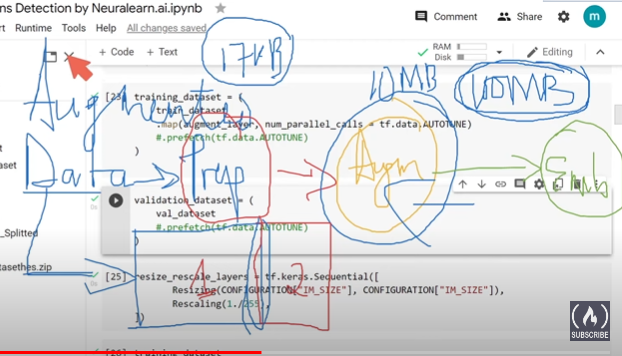

- TenasorFlow Record help to easily manage the dataset pipeline 
- We will convert the dataset into the dataset record so that we don't have to read the data from every single small file

# TFRecord
- We first store dataset in the specific form
- In the form of `features` and `keys`
- Features are of different types. i.e. Bytes, int and float


In [4]:
unbatch_train_dataset = (train_dataset.unbatch())
unbatch_validation_dataset = (validation_dataset.unbatch())
unbatch_test_dataset = (test_dataset.unbatch())

In [ ]:
def serialize_example(image, label):
    print(image , label)
    feature = {
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image]))
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


# We have to convert image from tensor to int 

def create_example(image, label):
    
  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = Feature(
      int64_list=Int64List(value=[label]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))
  
  return example.SerializeToString()

def encode_image(image , label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image , tf.argmax(label)



In [ ]:
NUM_SHARDS = 10
PATH = "./HUMAN_EMOTION_TFRECORD/TF_SHARD_{:02d}.tfrecord"

In [ ]:
encoded_unbatch_train_dataset = (unbatch_train_dataset.map( encode_image))


In [ ]:
for shard in range(NUM_SHARDS):
    process_shard = (encoded_unbatch_train_dataset
                     .shard(NUM_SHARDS, shard)
                     .as_numpy_iterator())
                     # This is when the Eagor Tensor type Error occurs  
    with tf.io.TFRecordWriter(PATH.format(shard)) as writer:
        for (image , label) in process_shard:
            example = serialize_example(image, label)
            writer.write(example)

In [ ]:
filenames = [PATH.format(p) for p in range(NUM_SHARDS) ]
print(filenames)

In [ ]:
recon_dataset = tf.data.TFRecordDataset(filenames = [PATH.format(p) for p in range(NUM_SHARDS) ])


In [ ]:
print(recon_dataset)

In [ ]:
def parse_tfrecord(example):
    feature_description = {
        "images" : tf.io.FixedLenFeature([] , tf.string),
        "labels" : tf.io.FixedLenFeature([] , tf.int64)
    }
    example = tf.io.parse_single_example(example , feature_description)
    print("----------")
    # We have to apply the reverse operations that we have applied above
    example["images"] = tf.io.decode_jpeg(example["images"] , channels=3)
    example["images"] = tf.image.convert_image_dtype(example["images"] , tf.float32)
    return example["images"] , example["labels"]

parsed_dataset = (recon_dataset.map(parse_tfrecord))

In [ ]:
print(parsed_dataset)
print(unbatch_train_dataset)

In [ ]:
for i in parsed_dataset.take(1):
    print(i)

In [ ]:
parsed_dataset = parsed_dataset.batch(32)
single_batch_data_visualization(parsed_dataset)

In [ ]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)
    
    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

In [ ]:
# class ResidualBlock(Layer):  
#   def __init__(self,num_channels , strides = 1):
#     super(ResidualBlock, self).__init__(name = 'residual_block')
#     self.custom_conv_1 = CustomConv2D(num_channels, 3 , strides, padding='same')
#     self.custom_conv_2 = CustomConv2D(num_channels, 3 , 1, padding='same')
#     # When stride = 1 we can add the above two layers
#     # When stride = 2 or any other we need to add a 1x1 conv layer to the input layer, so to match with the x
#     self.activation = Activation('relu')
#     self.dotting = (strides != 1)

#     if self.dotting:
#       self.conv_3 = CustomConv2D(num_channels, 1 , strides)
    
#     def call(self, inputs , training):
#       x = self.custom_conv_1(inputs , training)
#       x = self.custom_conv_2(x , training)

#       if self.dotting:
#         x_add = self.conv_3(inputs , training)
#         x_add = Add()([x, x_add])
#       else:
        
#         x_add = Add()([x, inputs])
      
#       return self.activation(x_add)




class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)  # According to Resnet

    # Jaha stride change ho raheen han, waheen channels 128/64  bhi change ho rahi model may waha hi dotted line hai

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

    
  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
      # So make channel or input and x as same
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)

In [ ]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')
    
    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)
    
    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)
    
    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)
    
    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')
    
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)
    
    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)
    
    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)
    
    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)
    
    return self.fc_3(x)

In [ ]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = False)
resnet_34.summary()

In [ ]:
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy , CategoricalAccuracy , TopKCategoricalAccuracy
# metrics = [CategoricalAccuracy(name = "accracy"), TopKCategoricalAccuracy(k=2 , name = "top2_accracy")]
metrics = [binary_accuracy, top_k_categorical_accuracy]
resnet_34.compile(optimizer='adam', loss='categorical_crossentropy', metrics = metrics)
resnet_34.summary()

In [ ]:
checkpoint_filepath = "./ResNet34_Checkpoints"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_format='tf',
    mode='max',
    verbose = 1,
    save_best_only=False,
    )


In [ ]:
# resnet_34.load_weights("ResNet34_Checkpoints")

In [ ]:
resnet_34.fit(train_dataset , validation_data= validation_dataset , epochs= 2 , verbose = 1 , callbacks = [model_checkpoint_callback])

In [ ]:
resnet_34.evaluate(test_dataset)

## Load Model Checkpoints

In [ ]:
import tensorflow as tf

# Define the path to the saved checkpoint directory
checkpoint_filepath = "./ResNet34_Checkpoints"

# Load the saved model checkpoint
loaded_model = tf.keras.models.load_model(checkpoint_filepath)
loaded_model.summary()
# Now you can use the 'loaded_model' just like any other Keras model


In [ ]:
predicted_single_batch_data_visualization(test_dataset , resnet_34)

In [ ]:
plot_confusion_matrix(train_dataset , resnet_34)

# AlexNet
- Pooling layer help downsample the data
- Batchnormalization prevent from gradient vanishing and eploding problem. By makingg our data around same means and average
- Overlapping Pooling with stride = 2, so because our values don't repeat
- `Large kernel` extract large spatial context (to capture low level featuers) but are computationally expensive. so we implement this on the start of model to capture low `level features`. 
- `Top-1` means correct prediction is the top 1 probability of the output of model
- `Top-5` means correct prediction is one of the label in the top 5 probabilities in the output

# VGGNet [Visual Geometry Group]
- Extract `deep features` in the later layer we use `small kernel` sizes
- LRN local normalization don't help in training 

# ResNet
- Rely on residual block. 
- Low layers can have low error rate
- Build a `residual` connection to` prevent gradient vanishing` problem
- As large layer derivative will not affect the weight , so to preserve initial features we add a `residual block`
- To match layer size we do `1 by 1 convolution` the time we have to add extra channel to match layer
- We apply normalization (after convolution but before activate) to normalize the distributions. Also scale and shift before activation i.e. in Batch-Normalization
- This scale and shift parameters are trainable
- index of pixel don't matter then use Global (max of a single channel) Max Pooling


# MobileNet
- For device with low computational resources like mobile or edge devices
- Deothwise and point wise convolution (1x1 kernel size)
- In simple Convolution number of output channels are equal to number of filter 
- `Simple Convolution` No. of Output Channel = No. of Filters
- `Depthwise Convolution` Np. of channels = No. of channels
- Depthwise convolution done by applying filter on individual channel
- If we want to change the no of channel after depthwise then we apply addional 1x1 convolution with desired no. of channels 
- output_height = [(input_height + 2 * padding_height - filter_height) / stride] + 1
- When we goes from high dimension to low dimension, RELU losses information thereform we don't user RELU in last 
- We deal with layers containing low dimension (low no. of output channel)

# Efficient Net
- Mkaing the model efficient
- Scaling the model i.e. by increasing/decreasing the number of channel
- By changing channel, FLOPs no. of arithmetic operation for this model
- Sqeeze in excitation
- Depth increase the accuracy but oonly till the certain point

![image.png](attachment:image.png)


# Transfer Learning & Finetuning 
- We use the pretrained model and add the classification network at the end and freeze the pretrained weights so it didn't update during training
- In finetuning we donot freeze the end layer of pretrained model and by either using model.layer[] command to freeqe only the above layers and donot freeze the end layer of petrained model and so these end layers with out classification layers

In [10]:
backbone_effecient = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top=False, # do not include the Top layers in the training 
      weights='imagenet',
        input_shape = (CONFIGURATION["IM_SIZE"] , CONFIGURATION["IM_SIZE"] , 3)
        )


In [11]:

backbone_effecient.trainable = False   # So that the above model don't trained 

In [12]:
model_pretrained = tf.keras.Sequential([
    InputLayer( input_shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)),
    backbone_effecient , 
    GlobalAveragePooling2D(),
    Dense(CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense(CONFIGURATION["N_DENSE_2"], activation = "relu"),
    BatchNormalization(),
    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),
])

In [13]:
model_pretrained.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_pretrained.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_average_pooling2d_1   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 128)               131200    
                                                                 
 batch_normalization_3 (Batc  (None, 128)             

In [ ]:
history = model_pretrained.fit(
    train_dataset ,
    # train_dataset.take(3)
      validation_data=validation_dataset, epochs=3 , verbose = 1)

In [ ]:
model_pretrained.save_weights('model_pretrained_efficient.h5')

In [ ]:
model_pretrained.evaluate(test_dataset) 
predicted_single_batch_data_visualization(test_dataset , model_pretrained)

In [ ]:
plot_confusion_matrix(test_dataset , model_pretrained)

- Take cleaned data to also get pretty good validation accuracy

In [ ]:

plot_train_val_accuracy(history)

# Fine Tuning 

### `layer.trainable = True` is not equal to `training = True`

- layer.trainable means the weights will not update
but in batch normalization, training = true because we have to infer the normalize factor according to weights 
- trainable = false, it will take means etc of the moving batch, instead of the moving batch

# Trainable and Training during Fine Tuning
- For fine tunning we make layer.trainable = True so enable training
- But we make training = False as we donot want the batchnorm layer to updated normalizing factor on the current batch. 
- By making `training = false & Trainab;e = True` we make layers to train but not change the normalizing factor of the previous pretrained model


`Normalization factor previous dataset par set howa wa hai. ham Trainable - True say ya kehtay han kay weights to fine tunned ho jay but normalization factor change na ho`

In [ ]:
input = Input(shape = (CONFIGURATION["IM_SIZE"] , CONFIGURATION["IM_SIZE"] , 3))
backbone_effecient.trainable = True
x = backbone_effecient(input , training = False)   # so that the normalization factor don't change
x = GlobalAveragePooling2D()(x)
x = Dense(CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense(CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
x = BatchNormalization()(x)
output = Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)
finetuned_model = Model(input,output)

## During finetuning we have to make our `learning rate very small`

In [ ]:
finetuned_model.compile(optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]/100), loss='categorical_crossentropy', metrics=['accuracy'])
finetuned_model.summary()

## Visualizing Intermediate Layers

In [ ]:
vgg_model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights=None,
    input_shape=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"],3)
)
vgg_model.trainable = False
vgg_model.summary()



In [ ]:
function_map = [layer.output for layer in vgg_model.layers[1:] if 'conv' in layer.name]
function_map_model = Model(
    inputs = vgg_model.input,
    outputs = function_map
)
# print(len(function_map))
function_map_model.summary()


In [ ]:
import cv2
image = cv2.imread('D:/Tensorflow Basics/Human_Emotion_Dataset/EmotionsDataset_Splitted/data/train/happy/11.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (CONFIGURATION['IM_SIZE'] , CONFIGURATION['IM_SIZE']))
image = tf.constant(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
f_map = function_map_model.predict(image)

In [ ]:
plt.imshow(image[0].numpy().astype("uint8"))

In [ ]:
print(len(f_map))
print(f_map[1].shape)

In [ ]:
def plot_intermediate_layer(f_map):
    for i in range(len(f_map)):
        plt.figure(figsize=(256, 256))
        input_size  = f_map[i].shape[1]
        num_channels  = f_map[i].shape[3]
        joint_maps = np.ones((input_size, num_channels*input_size))
        for j in range(num_channels):
            joint_maps[:, j*input_size:(j+1)*input_size] = f_map[i][..., j]
        plt.imshow(joint_maps[: 0:25])  
        plt.axis('off')
        
plot_intermediate_layer(f_map)

# Grad CAM


- First Differentiate the classification and the last logists layer
- Find the prediction
- Find the gradient of prediction with respect to the last layer, as pred is find by seprating moving the image from `last layer model` and then `classification model`
- Element wise multiplication Multiple gradients with the last layer array.
- As number of gradient values is equal to the number of channel
- Then the respective values of channel added and plot the image. 
- Find the relu of the final last layer heatmap
- This is the heatmap of the last layer with respect the prediction 
 

In [5]:
pretrained_efficientB5 = tf.keras.applications.efficientnet.EfficientNetB5(
include_top=False,
 weights='imagenet', input_shape=(CONFIGURATION['IM_SIZE'] , CONFIGURATION['IM_SIZE'] , 3 )
 
 
 
 )
 

### To get the backbone full you have to define the model such that 

In [ ]:
### To get the backbone full you have to define the model such that 

# input = Input(shape = (CONFIGURATION["IM_SIZE"] , CONFIGURATION["IM_SIZE"] , 3))

pretrained_efficientB5.trainable = False
x = pretrained_efficientB5.output
x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

pretrained_model  = Model(   pretrained_efficientB5.inputs    ,output   )

pretrained_model.summary()

- `Layer above the globalnormalization is the last layer`
- Below the globalaverage layer is the classification layer

In [ ]:
last_conv_layer = "top_activation"
last_conv_layer = pretrained_efficientB5.get_layer(last_conv_layer)
last_conv_layer_model = Model(pretrained_efficientB5.inputs, last_conv_layer.output)

In [ ]:
classification_name = [
    "global_average_pooling2d_2",
    "dense_6",
    "dense_7",
    "dense_8",
]

# last_conv_layer_model_output = last_conv_layer_model.output
classify_input = Input(shape=( 8,8,2048))
x = classify_input
for name in classification_name:
    x = pretrained_model.get_layer(name)(x)

classification_model = Model(classify_input, x)




In [ ]:
pred_sample = pretrained_model.predict(image)

In [ ]:
print(pred_sample.shape)
print(pred_sample)
print(tf.argmax(pred_sample[0]))

In [ ]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(image)
    pred = classification_model(last_conv_layer_output)
    top_pred_index = tf.argmax(pred[0])
    top_class_channel = pred[:, top_pred_index]  # Value of the top prediction

    
grad = tape.gradient(top_class_channel, last_conv_layer_output)
print(grad.shape)
popoled_grads = tf.reduce_mean(grad, axis = (0,1,2)).numpy() # This is used to get the mean of every channel

print(popoled_grads.shape[0])

### To pass through the model, we pass the batch of 1 but now we will plot the last layer so sequees the batch to simple3-D tensor for plotting

In [ ]:
print(last_conv_layer_output.shape)
last_conv_layer_output = tf.squeeze(last_conv_layer_output , axis = 0)  # Convert the tensor to numpy array
# to pass through the model, we pass the batch of 1 but now we will plot the last layer so sequees the batch to simple3-D tensor for plotting
print(last_conv_layer_output.shape)

last_conv_layer_output = tf.math.multiply(last_conv_layer_output, popoled_grads) # Element wise multiplication of the last classification prediction with the lasts convolution layer (last convolutional layer is the pretrained of the pretrained model)


In [ ]:

print(last_conv_layer_output.shape)

#Heatmap of last convolutional layer after the gradient
last_conv_layer_output_image = np.sum(last_conv_layer_output, axis=-1) # sum over all channels
print(last_conv_layer_output_image.shape)

In [ ]:
heatmap_last_conv_layer = tf.nn.relu(last_conv_layer_output_image)
heatmap_last_conv_layer=cv2.resize(np.array(heatmap_last_conv_layer),(256,256))

plt.matshow(heatmap_last_conv_layer, cmap='viridis')

## Matshow is used to show image of 2-Dimension

In [ ]:

# -------------- Approach 1 ------------------ #
temp = np.sum(image, axis = -1)
plt.matshow(heatmap_last_conv_layer*255 + image[0, : ,:, 0 ]/255)

# -------------- Approach 2 ------------------ #
temp = np.sum(image, axis = -1)
plt.matshow(heatmap_last_conv_layer*255 + temp[0]/255)

# Take the last layer, we want to show the image with low opacity
# We take only 1 layer of the image, the last one, and we add the heatmap to it. 


# Vision Transformers

- Encoder and Decoders are used as we have different input and output dimensions
- We make embeddings of every input word and then pass it to the Self Attention layer
- Embedding of every word is a vector of for example 3 dimensions (positive , negative and neutral)
- We apply the dot product attention, multiple the transpose of this embedding matrix 
- We apply self attention layer, which will replace RNNs as instead of using the RNNs we apply the technique of attention, like value of one input to another 
- And again using the Adding resiudla layer like ResNets and apply norms. Wecan use attention block as memory for sequential data
- Input is subsample to 3 values Q-V-K and pass to linear layers called `heads` and then pass to the `scales multiplication`
- We donot use the Batching the Visual tranformer because this will effect the batch gradient and in case of NLPs this batch will effect greatly
- MLP are the fully connected layers in ViT
- As the single attention layer will learn the feature of first part and the last, so unlike the convolution where we learn the low level feature in the start and the high level feature at the end. By using usign ViT we can make the model to learn the low levell and high level features right from the start
- `Num Heads = h` means how many layer will be there in the Scales Dot-Product attention,  after the linear layer 
-  We used `Gelu` instead of relu because gelu is smooth  and it has non zero mean 

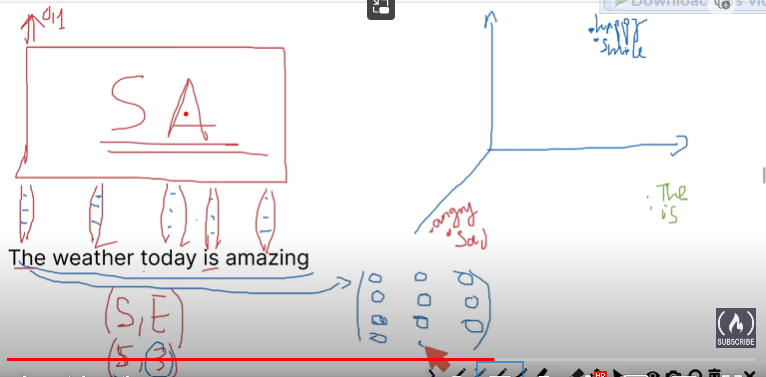
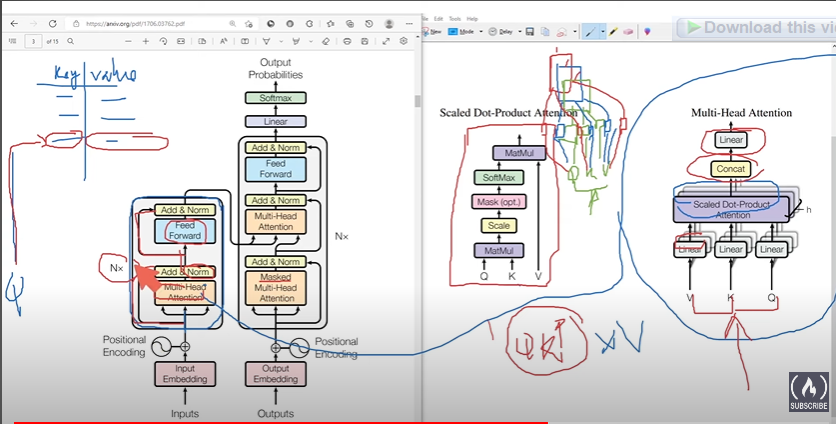

### Extract Patch from images

In [ ]:
tf.image.extract_patches(images=images,
                           sizes=[1, 3, 3, 1],
                           strides=[1, 5, 5, 1],
                           rates=[1, 1, 1, 1],   # How much distance between each pixel of filter. i.e. For Dilated Filter
                           padding='VALID')

- #### Input shape is `(Batch , No of patches , Hidden Dimension)` (1 , 256 , 768) 256 patched and each patch has 768 hidden feature for a single image of (256 , 256 , 3)   

In [ ]:
# tf.keras.layers.Embedding(
#     input_dim,
#     output_dim,
#     embeddings_initializer="uniform",
#     embeddings_regularizer=None,
#     activity_regularizer=None,
#     embeddings_constraint=None,
#     mask_zero=False,
#     input_length=None,
#     sparse=False,
#     # **kwargs
# )

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(256, 768))  # Total 259 embedding layers. It convert each input to 768 embededings
# The model will take as input an integer matrix of size (batch,input_length), and the largest integer (i.e. word index) in the input
# should be no larger than 999 (vocabulary size).
# Now model.output_shape is (None, 10, 64), where `None` is the batch
# dimension.
input_array = np.random.randint(low = 1000, size=(1,256)) # All values are smaller than low
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array.shape)
# (32, 10, 64)

In [ ]:
# We will make this layer, keeping into account of the input data is in the form of Batch 
class patchEncoder(Layer):
    # Hidden unit is referred to term as the no of Features. 256 images and each image has 768 features
    def __init__(self , N_PATCHES , HIDDEN_SIZE):
        super(patchEncoder , self).__init__()

        self.linear_projection = Dense(units=HIDDEN_SIZE)   #   shape (2 , 3) with dense = 768  --> (2 , 768)
        self.positional_embedding = Embedding(input_dim=N_PATCHES , output_dim=HIDDEN_SIZE)  #   shape (16) with output = 5  --> (16 , 5)
        self.N_PATCHES = N_PATCHES
    def call(self , x):
        patches = tf.image.extract_patches(images=x , 
                                           sizes=[1 , CONFIGURATION["PATCH_SIZE"] , CONFIGURATION["PATCH_SIZE"] , 1] ,
                                           strides=[1 , CONFIGURATION["PATCH_SIZE"] , CONFIGURATION["PATCH_SIZE"]  , 1] ,
                                           rates=[1 , 1 , 1 , 1] , padding='VALID')
        print(patches.shape)
        # patches = tf.reshape(patches , shape =  (patches.shape[0] , -1 , patches.shape[-1])) # (batch_size , N_PATCHES ,HIDDEN_SIZE)
        patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1]))

        embedding_input = tf.range(start=0 , limit=self.N_PATCHES , delta=1) # (N_PATCHES)
        output = self.linear_projection(patches) + self.positional_embedding(embedding_input) # This output is a trainable parameter
        return output


In [ ]:
class TransformerEncoder(Layer):
    # key_dims is same as of the Hidden Units
    def __init__(self , H_HEADS , HIDDEN_SIZE):
        super().__init__()

        self.norm = LayerNormalization()
        # Key dimensions determine how many feature each frame/patche will be
        # This can be understand by the working of MultiHead Attention Layer  
        self.multi_head_attention = MultiHeadAttention(num_heads=H_HEADS , key_dim=HIDDEN_SIZE) 
        self.dense_1 = Dense(units=HIDDEN_SIZE , activation=tf.nn.gelu)
        self.dense_2 = Dense(units=HIDDEN_SIZE , activation=tf.nn.gelu)

    def call(self , input):
        # --------- This all logic is from the official tranformer paper ------------  #
        x = self.norm(input)
        x = self.multi_head_attention(x , x)  # We have to place the query adn the values 
        x_1 = Add()([input , x])
        x_2 = self.norm(x_1)
        x_2 = self.dense_1(x_2)
        x_2 = self.dense_2(x_2)
        output = Add()([x_1 , x_2])
        return output

In [ ]:
patch_encoder = patchEncoder(256 , 768)
transformer_encoder = TransformerEncoder(8 , 768)

output_patch = patch_encoder(tf.zeros(  [1, 256, 256 , 1]  ))


In [ ]:

output_transformer = transformer_encoder(  output_patch  )


In [ ]:
print(output_transformer.shape)

In [ ]:
print(output_patch)
print(output_patch.shape)

In [ ]:
class ViT(Model):
  def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):
    super(ViT, self).__init__(name = 'vision_transformer')
    self.N_LAYERS = N_LAYERS
    self.patch_encoder = patchEncoder(N_PATCHES, HIDDEN_SIZE)
    self.trans_encoders = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
    self.dense_1 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_2 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')
  def call(self, input, training = True):

    x = self.patch_encoder(input)

    for i in range(self.N_LAYERS):
      x = self.trans_encoders[i](x)
    x = Flatten()(x)
    x = self.dense_1(x)
    x = self.dense_2(x)
    
    return self.dense_3(x)

In [ ]:

vit = ViT(
    N_HEADS = 4, HIDDEN_SIZE = 768, N_PATCHES = 256,
    N_LAYERS = 2, N_DENSE_UNITS = 128)
vit(tf.zeros([2,256,256,3]))

In [ ]:
vit.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vit.summary()

In [ ]:
vit.fit(train_dataset , validation_data=validation_dataset , epochs=5 , verbose=1)

In [ ]:
# !pip install transformers


## Vit From Hugging Face

- Intermediate size is the size of dense layer before the output dense 
- `epsilon` is normalization (  ( x -x1 / varian + epsilon) . i..e just to pevent the small values, we make epsilon very small
- `TFViTModel` is used to make ViT model on Tensorflow

In [ ]:
    def __init__(
        self,
        hidden_size=768,
        num_hidden_layers=12,
        num_attention_heads=12,
        intermediate_size=3072,   # This intermediate size is the size of dense layer before output dense layer
        hidden_act="gelu",
        hidden_dropout_prob=0.0,
        attention_probs_dropout_prob=0.0,
        initializer_range=0.02,
        layer_norm_eps=1e-12,
        image_size=224,
        patch_size=16,
        num_channels=3,
        qkv_bias=True,
        encoder_stride=16,
        **kwargs,
    ):

In [9]:
from transformers import  TFViTModel ,  ViTModel , ViTConfig

c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
configuration = ViTConfig()

print(configuration)
configuration = ViTConfig(hidden_size=144 , )
print(configuration)
Vit_sample_model = TFViTModel(configuration)
# print(Vit_sample_model.config)

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.31.0"
}

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 144,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.31.0"
}



In [11]:
# ------- Documentation for Hugging Face -------------------#

# from transformers import AutoImageProcessor, ViTModel
# import torch
# from datasets import load_dataset

# dataset = load_dataset("huggingface/cats-image")
# image = dataset["test"]["image"][0]

# image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
# model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

# inputs = image_processor(image, return_tensors="pt")

# with torch.no_grad():
#     outputs = model(**inputs)

# last_hidden_states = outputs.last_hidden_state
# list(last_hidden_states.shape)
# [1, 197, 768]

In [12]:
# inputs = image_processor(image, return_tensors="pt")
# If we have individual images we can process it 

In [21]:
resize_rescale = tf.keras.Sequential([  
    Resizing(224, 224),
    Rescaling(1./255),
    Permute((3 ,2,1)) 
    # We have to make the first dimension as Channel to feed it to the ViT model
])

## We have to chaneg the last layre according to our dense layer during loading
- As we will take the specific output from the lat hidden state. 
- You can see the last hidden state by inspecting the summary() of the model

In [31]:

base_vit_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

input_vit  = Input(shape=(256, 256 , 3), name='input_vit')
input_vit_processes = resize_rescale(input_vit)
# For vit moodel we need make the first dimension as channel
x = base_vit_model.vit(input_vit_processes)[0][: , 0,:] 

output = Dense (CONFIGURATION ['NUM_CLASSES'], activation='softmax')(x)
hf_model = Model(inputs=input_vit, outputs=output)


All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [32]:
hf_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_vit (InputLayer)      [(None, 256, 256, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem_2   (None, 768)              0   

### Learning Rate should be small when you are doing fine tunning

In [34]:

hf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 5e-4), loss='categorical_crossentropy', metrics=['accuracy'])
hf_model.fit(train_dataset.take, epochs=10, verbose = 1)


Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node 'model_3/vit/encoder/layer_._0/intermediate/Gelu/truediv' defined at (most recent call last):
    File "c:\Users\Pc\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Pc\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 728, in start
      self.io_loop.start()
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Pc\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Pc\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Pc\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Pc\AppData\Local\Temp\ipykernel_11304\1702801219.py", line 2, in <module>
      hf_model.fit(train_dataset.take(3), epochs=10, verbose = 1)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\transformers\modeling_tf_utils.py", line 506, in run_call_with_unpacked_inputs
      # EagerTensors don't allow to use the .name property so we check for a real Tensor
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 519, in call
      encoder_outputs = self.encoder(
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 438, in call
      for i, layer_module in enumerate(self.layer):
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 442, in call
      layer_outputs = layer_module(
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 409, in call
      intermediate_output = self.intermediate(hidden_states=layer_output)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 348, in call
      hidden_states = self.intermediate_act_fn(hidden_states)
    File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\keras\activations.py", line 359, in gelu
      return tf.nn.gelu(x, approximate)
Node: 'model_3/vit/encoder/layer_._0/intermediate/Gelu/truediv'
failed to allocate memory
	 [[{{node model_3/vit/encoder/layer_._0/intermediate/Gelu/truediv}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_413321]

In [ ]:
hf_model.save_weights('pretrained_ViT.h5')

In [14]:
import wandb
wandb.config  = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 4,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "nothing", "sad"],
}

CONFIGURATION = wandb.config


In [15]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: ahsanbilal. Use `wandb login --relogin` to force relogin


True

In [16]:
wandb.init(project="Human-Emotion")

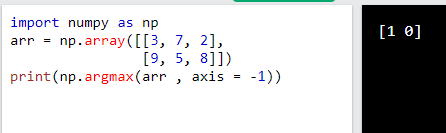

### .numpy() is to convert the tensors to the numpy values

In [17]:
for i , label in unbatch_test_dataset.take(23):
    print(label.numpy())
    break

[1. 0. 0. 0.]


### For Confusion Matrix
- For the confusion matrix we have taken the batched datsaet. 
### For Table
- For the table, we have taken the unbatched dataset. That's why I have applied the extra dimension in the image while prediction 

In [18]:
class logConfusionCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        pred = []
        label = []
        for im , labels in test_dataset:
            predicted = model_pretrained.predict(im)
            pred.append(predicted)
            label.append(labels.numpy())

        pred_labels = np.concatenate( [np.argmax(pred[:-1], axis=-1).flatten() , np.argmax(pred[-1], axis=-1).flatten() ])
        true_labels = np.concatenate( [np.argmax(label[:-1], axis=-1).flatten() , np.argmax(label[-1], axis=-1).flatten() ])
        cm = wandb.plot.confusion_matrix(y_true= true_labels , preds=pred_labels, class_names=CONFIGURATION["CLASS_NAMES"])
        wandb.log({"confusion matrix": cm})

class logImagesCallback(Callback):
    def on_epoch_end(self , epoch , logs):
        column = ["image" , "predicted" , "truth"]
        test_table = wandb.Table(columns=column)

        for im , label in unbatch_test_dataset.take(25):
            
            predicted = model_pretrained( tf.expand_dims(im , axis = 0 ))
            # print("---------",predicted)
            predicted_label = np.argmax(predicted , axis=-1)[0]
            # print("---------",predicted_label)
            # print("---------",label)
            true_label = np.argmax(tf.expand_dims( label , axis  = 0 ) , axis=-1)[0]
            # print(predicted_label)
            # print(true_label)
            predicted_name = CONFIGURATION["CLASS_NAMES"][predicted_label]
            truth_name = CONFIGURATION["CLASS_NAMES"][true_label]
            # print(predicted_name)
            # print(truth_name)
            ROW = [wandb.Image(im) , predicted_name , truth_name]
            test_table.add_data(*ROW)

        wandb.log({"Test Table": test_table})


conf_callback = logConfusionCallback()
table_callback = logImagesCallback()

In [19]:

history = model_pretrained.fit(train_dataset,epochs=4, batch_size=32, validation_data= validation_dataset , callbacks=([conf_callback ,  table_callback]) , verbose=1)

Epoch 1/4
79/79 [==============================] - 74s 686ms/step - loss: 0.7303 - accuracy: 0.7006 - val_loss: 0.5935 - val_accuracy: 0.7444
Epoch 2/4
79/79 [==============================] - 49s 624ms/step - loss: 0.5167 - accuracy: 0.7831 - val_loss: 0.5904 - val_accuracy: 0.7413
Epoch 3/4
79/79 [==============================] - 47s 593ms/step - loss: 0.4678 - accuracy: 0.8013 - val_loss: 0.6094 - val_accuracy: 0.7206
Epoch 4/4
79/79 [==============================] - 47s 592ms/step - loss: 0.4314 - accuracy: 0.8239 - val_loss: 0.5920 - val_accuracy: 0.7524


In [14]:
model_pretrained.load_weights('model_pretrained_efficient.h5')

In [4]:
!python -m tf2onnx.convert --save_model model_pretrained_efficient.h5 --output model_pretrained_efficient.onnx

Traceback (most recent call last):
  File "c:\Users\Pc\miniconda3\envs\tf\lib\runpy.py", line 188, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "c:\Users\Pc\miniconda3\envs\tf\lib\runpy.py", line 111, in _get_module_details
    __import__(pkg_name)
  File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\tf2onnx\__init__.py", line 10, in <module>
    from . import verbose_logging as logging
  File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\tf2onnx\verbose_logging.py", line 14, in <module>
    import tensorflow as tf
  File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\tensorflow\__init__.py", line 37, in <module>
    from tensorflow.python.tools import module_util as _module_util
  File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\tensorflow\python\__init__.py", line 37, in <module>
    from tensorflow.python.eager import context
  File "c:\Users\Pc\miniconda3\envs\tf\lib\site-packages\tensorflow\python\eager\context

In [20]:
wandb.finish()